# Dependencies installation
we'll first try to fetch a pre-installed dependencies from google-drive, if it doesn't exist, we'll install it there for faster loading next *time*

In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np

from src import multi_run
from src.channel_simulation import ChannelSimulator
from src.split_step_fourier import SplitStepFourier
from src.visualizer import Visualizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Deep Learning research

## BER vs normalization factor

number of iterations in split step algo: 11
normalizing factors are: [3.16e-04 4.52e-04 6.46e-04 9.24e-04 1.32e-03 1.89e-03 2.70e-03 3.86e-03
 5.51e-03 7.88e-03 1.13e-02 1.61e-02 2.30e-02 3.29e-02 4.70e-02 6.72e-02
 9.61e-02 1.37e-01 1.96e-01 2.81e-01 4.01e-01 5.74e-01 8.20e-01 1.17e+00
 1.68e+00 2.40e+00 3.42e+00 4.89e+00 7.00e+00 1.00e+01]


100%|██████████| 900/900 [01:14<00:00, 12.05it/s]


64 symbols: errors found = [2929 2918 2940 2918 2880 2890 2860 2951 2864 2842 2900 2834 2855 2767
 2838 2781 2822 3213 3722 3911 3925 3962 3763 3837 3810 3812 3858 3806
 3767 3830] / [7680 = 256 bits * 30 realisations]


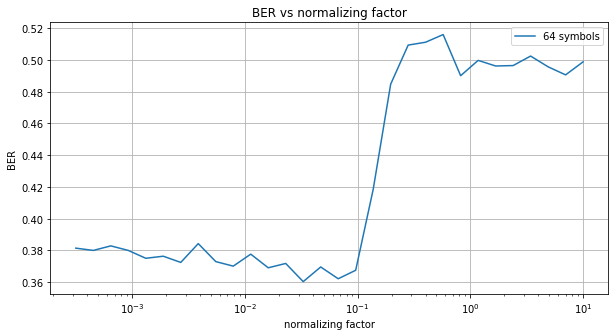

In [11]:
# test the impact of ber vs normalization factor for multiple n_symbols
ssf = SplitStepFourier(
    alpha=0,
    b2=-20e-27,
    gamma=0.003,
    t0=125e-12,
    last_step=1.51e-3,
    dt=1e-12,
    h=100
)
cs = ChannelSimulator(m_qam=16, verbose=False, channel_func=ssf)

num_realisations = 30
us_vec = multi_run.create_us_vec(n_steps=30, min_u=-3.5, max_u=1)
N_symbols_vec = np.array([64])#, 128, 256, 512])

with np.printoptions(precision=2):
    print(f'normalizing factors are: {us_vec}')

    bers_vec, legends = [], []
    for n_sym in N_symbols_vec:
        cs.num_symbols = n_sym
        bers, errs = multi_run.ber_vs_us(cs, us_vec, n_realisations=num_realisations)
        print(f'{n_sym} symbols: errors found = {errs} / [{cs.length_of_msg * num_realisations} '
              f'= {cs.length_of_msg} bits * {num_realisations} realisations]')
        bers_vec.append(bers)
        legends.append(f'{n_sym} symbols')

Visualizer.plot_bers(us_vec, bers_vec, legends)


In [ ]:
# test the impact of ber vs normalization factor for multiple n_symbols
ssf = SplitStepFourier(
    alpha=0,
    b2=-20e-27,
    gamma=0.003,
    t0=125e-12,
    last_step=1.51e-3,
    dt=1e-12,
    h=100
)
cs = ChannelSimulator(m_qam=16, verbose=False, channel_func=ssf)

num_realisations = 30
us_vec = multi_run.create_us_vec(n_steps=30, min_u=-3.5, max_u=1)
N_symbols_vec = np.array([64, 128, 256, 512])

with np.printoptions(precision=2):
    print(f'normalizing factors are: {us_vec}')

    bers_vec, legends = [], []
    for n_sym in N_symbols_vec:
        cs.num_symbols = n_sym
        bers, errs = multi_run.ber_vs_us(cs, us_vec, n_realisations=num_realisations)
        print(f'{n_sym} symbols: errors found = {errs} / [{cs.length_of_msg * num_realisations} '
              f'= {cs.length_of_msg} bits * {num_realisations} realisations]')
        bers_vec.append(bers)
        legends.append(f'{n_sym} symbols')

Visualizer.plot_bers(us_vec, bers_vec, legends)

number of iterations in split step algo: 11
normalizing factors are: [3.16e-04 4.52e-04 6.46e-04 9.24e-04 1.32e-03 1.89e-03 2.70e-03 3.86e-03
 5.51e-03 7.88e-03 1.13e-02 1.61e-02 2.30e-02 3.29e-02 4.70e-02 6.72e-02
 9.61e-02 1.37e-01 1.96e-01 2.81e-01 4.01e-01 5.74e-01 8.20e-01 1.17e+00
 1.68e+00 2.40e+00 3.42e+00 4.89e+00 7.00e+00 1.00e+01]


100%|██████████| 900/900 [01:14<00:00, 12.12it/s]


64 symbols: errors found = [2958 2969 2885 2923 2926 2911 2909 2877 2905 2882 2899 2902 2867 2827
 2810 2802 2894 3117 3775 3888 3819 3825 3870 3811 3819 3893 3827 3798
 3802 3810] / [7680 = 256 bits * 30 realisations]


100%|██████████| 900/900 [02:40<00:00,  5.59it/s]


128 symbols: errors found = [5623 5775 5758 5725 5743 5679 5719 5730 5811 5731 5807 5679 5546 5569
 5620 5682 6401 7495 7605 7759 7710 7652 7779 7742 7709 7741 7713 7714
 7662 7800] / [15360 = 512 bits * 30 realisations]


 58%|█████▊    | 524/900 [03:45<02:38,  2.37it/s]

TODOs:
moved to "Notes and texts".TODO.ipynb